In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
torch.__version__

'2.0.0+cu118'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Get some names from https://github.com/MASTREX/List-of-Indian-Names

In [5]:
!wget https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv -O names-long.csv

--2023-03-31 17:00:55--  https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85538 (84K) [text/plain]
Saving to: ‘names-long.csv’

names-long.csv      100%[===================>]  83.53K  --.-KB/s    in 0.07s   

2023-03-31 17:00:55 (1.12 MB/s) - ‘names-long.csv’ saved [85538/85538]



In [6]:
!head names-long.csv

,Name
0,aabid
1,aabida
2,aachal
3,aadesh
4,aadil
5,aadish
6,aaditya
7,aaenab
8,aafreen


In [7]:
words = pd.read_csv('names-long.csv')["Name"]
words = words.str.lower()
words = words.str.strip()
words = words.str.replace(" ", "")

words = words[words.str.len() > 2]
words = words[words.str.len() < 10]

# Randomly shuffle the words
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

# Remove words having non alphabets
words = [word for word in words if word.isalpha()]
words[:10]


['sehran',
 'iema',
 'bajinder',
 'manoj',
 'nayaka',
 'ajmal',
 'navleen',
 'akhtari',
 'samsung',
 'imtyaz']

In [8]:
len(words)

6184

In [9]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [10]:
block_size = 4 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [11]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([44325, 4]), torch.int64, torch.Size([44325]), torch.int64)

In [12]:
# Embedding layer for the context

emb_dim = 2
emb = torch.nn.Embedding(len(stoi), emb_dim)


In [13]:
emb.weight

Parameter containing:
tensor([[-0.7321, -0.0133],
        [ 0.9890, -0.3715],
        [-1.2565, -0.3346],
        [ 0.3989,  1.4209],
        [-0.5718, -0.1615],
        [ 0.4853,  2.2499],
        [ 0.1107,  2.7214],
        [-1.7009,  1.1288],
        [-0.6636, -1.1188],
        [-1.6768,  1.0876],
        [ 0.1645,  0.0063],
        [-1.0367, -0.9603],
        [-3.0939,  1.9831],
        [-0.8332,  0.8572],
        [-1.4305, -0.6878],
        [-0.5197, -0.9626],
        [-2.3395,  0.6205],
        [-0.7045,  0.2387],
        [ 2.8074, -0.8545],
        [-0.2396, -0.7623],
        [-1.1135, -0.1288],
        [-0.5464, -0.0345],
        [-1.2686,  1.0719],
        [-1.3973, -0.5510],
        [ 0.9127,  1.2566],
        [ 0.6278,  1.1915],
        [ 0.0465,  1.2633]], requires_grad=True)

<AxesSubplot:>

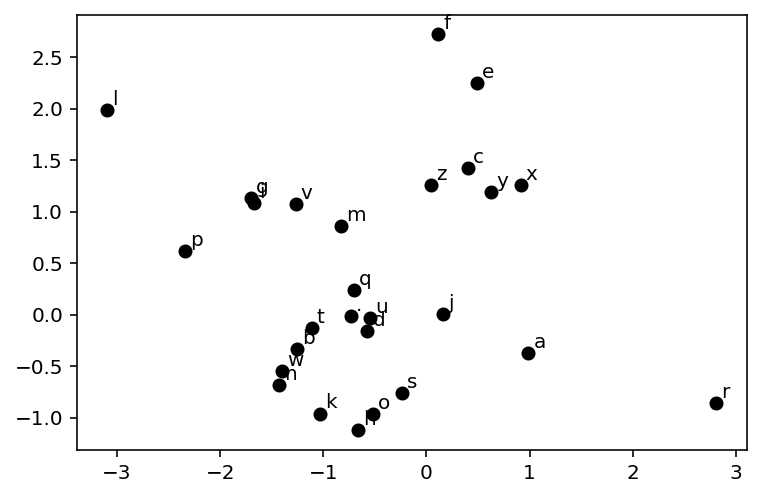

In [14]:
# Function to visualize the embedding in 2d space

def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        x, y = emb.weight[i].detach().cpu().numpy()
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

In [15]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = F.relu(self.lin1(x))
    x = self.lin2(x)
    return x
    

In [21]:
# Generate names from untrained model


model = NextChar(block_size, len(stoi), emb_dim, 50).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:90: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


ihjzyewjrp
puijjpnwfk
gcvvflic
eeokqgmlse
yiaghsikiv
smmggfnsot
ptdmdlmwfi
yitpyixshw
gjqapafodl
dfuhgoowtb


In [17]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

emb.weight torch.Size([27, 2])
lin1.weight torch.Size([50, 8])
lin1.bias torch.Size([50])
lin2.weight torch.Size([27, 50])
lin2.bias torch.Size([27])


In [25]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096*32
print_every = 400
elapsed_time = []
for epoch in range(10000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())
        print("Time taken for 1 epochs: {} seconds".format(sum(elapsed_time)/print_every))


0 2.0890238285064697
Time taken for 1 epochs: 6.577968597412109e-06 seconds
400 2.0890519618988037
Time taken for 1 epochs: 0.0018871128559112549 seconds
800 2.088754177093506
Time taken for 1 epochs: 0.0037400954961776733 seconds
1200 2.0887293815612793
Time taken for 1 epochs: 0.005593389868736267 seconds
1600 2.0884861946105957
Time taken for 1 epochs: 0.007446771860122681 seconds
2000 2.0891528129577637
Time taken for 1 epochs: 0.009300289154052734 seconds
2400 2.0879929065704346
Time taken for 1 epochs: 0.011153245568275452 seconds
2800 2.088449239730835
Time taken for 1 epochs: 0.013006348609924317 seconds
3200 2.0879693031311035
Time taken for 1 epochs: 0.014860434532165527 seconds
3600 2.0881006717681885
Time taken for 1 epochs: 0.016712880134582518 seconds
4000 2.087575912475586
Time taken for 1 epochs: 0.01856597661972046 seconds
4400 2.087235689163208
Time taken for 1 epochs: 0.020418978929519653 seconds
4800 2.087622880935669
Time taken for 1 epochs: 0.02227234423160553 sec

<AxesSubplot:>

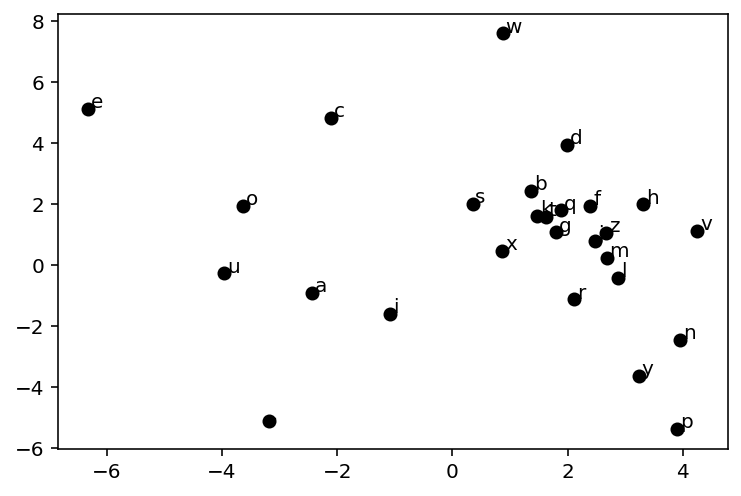

In [26]:
# Visualize the embedding

plot_emb(model.emb, itos)

In [27]:
# Generate names from trained model

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

swina
miter
jakul
poshaban
nahmishsir
jaillanam
fibwahir
gurs
sakinu
ramta


Tuning knobs

1. Embedding size
2. MLP 
3. Context length